In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
from IPython.display import display


In [5]:
# Load dataset
file_path = "/content/weatherHistory.csv"
df = pd.read_csv(file_path)

# Convert 'Formatted Date' to datetime and remove timezone
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True).dt.tz_localize(None)
df.set_index('Formatted Date', inplace=True)

# Select relevant features
df = df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Daily Summary']]

# Handle missing values
numerical_columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
df['Daily Summary'] = df['Daily Summary'].fillna(df['Daily Summary'].mode()[0])

# Encode 'Daily Summary'
label_encoder = LabelEncoder()
df['Daily Summary Encoded'] = label_encoder.fit_transform(df['Daily Summary'])
df.drop(columns=['Daily Summary'], inplace=True)

# Normalize the numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)


<ipython-input-5-68b1441dadaa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
<ipython-input-5-68b1441dadaa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily Summary'] = df['Daily Summary'].fillna(df['Daily Summary'].mode()[0])
<ipython-input-5-68b1441dadaa>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [6]:
# Function to create sequences for single-step forecasting
def create_single_step_sequences(data, input_length=10):
    X, y = [], []
    for i in range(len(data) - input_length):
        X.append(data[i:i+input_length])  # Past `input_length` time steps
        y.append(data[i+input_length])  # Predict next time step
    return np.array(X), np.array(y)

# Define input length
input_length = 10

# Create sequences
X_single, y_single = create_single_step_sequences(scaled_data, input_length)

# Split into training (80%) and testing (20%) sets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_single, y_single, test_size=0.2, shuffle=False)

# Print dataset shape
print("X_train_s shape:", X_train_s.shape)
print("y_train_s shape:", y_train_s.shape)


X_train_s shape: (77154, 10, 5)
y_train_s shape: (77154, 5)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - loss: 0.0468 - mae: 0.1505 - val_loss: 0.0047 - val_mae: 0.0437
Epoch 2/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - loss: 0.0120 - mae: 0.0788 - val_loss: 0.0040 - val_mae: 0.0414
Epoch 3/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0033 - val_mae: 0.0344
Epoch 4/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - loss: 0.0073 - mae: 0.0550 - val_loss: 0.0028 - val_mae: 0.0298
Epoch 5/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - loss: 0.0065 - mae: 0.0500 - val_loss: 0.0028 - val_mae: 0.0300
Epoch 6/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0062 - mae: 0.0474 - val_loss: 0.0026 - val_mae: 0.0294
Epoch 7/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0059 - mae: 0.0459 - val_loss: 0.0026 - val_mae: 0.0290
Epoch 8/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - loss: 0.0058 - mae: 0.0450 - val_loss: 0.0025 - val_mae: 0.0278
Epoch 9/20
1206/1206 ━━━━━━━━━━━━━━

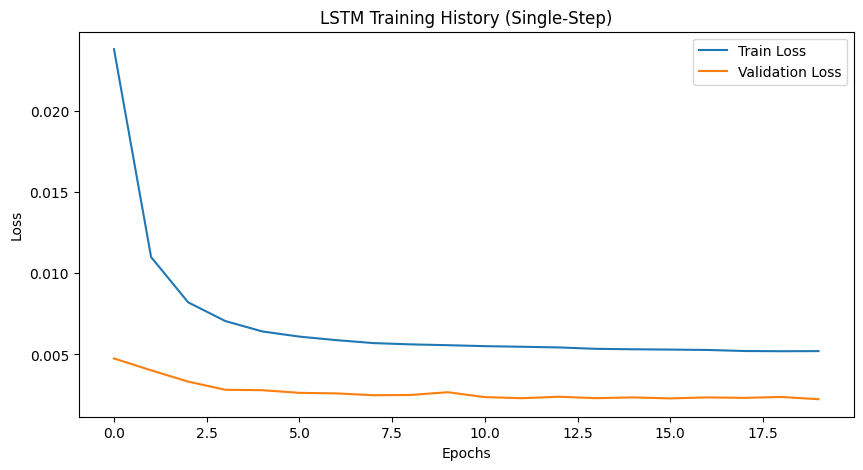

In [7]:
# Define LSTM model for single-step forecasting
model_single = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(input_length, X_train_s.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(X_train_s.shape[2])  # Predict only the next time step
])

# Compile the model
model_single.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history_single = model_single.fit(
    X_train_s, y_train_s,
    epochs=20, batch_size=64,
    validation_data=(X_test_s, y_test_s)
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history_single.history['loss'], label='Train Loss')
plt.plot(history_single.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training History (Single-Step)')
plt.show()


603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


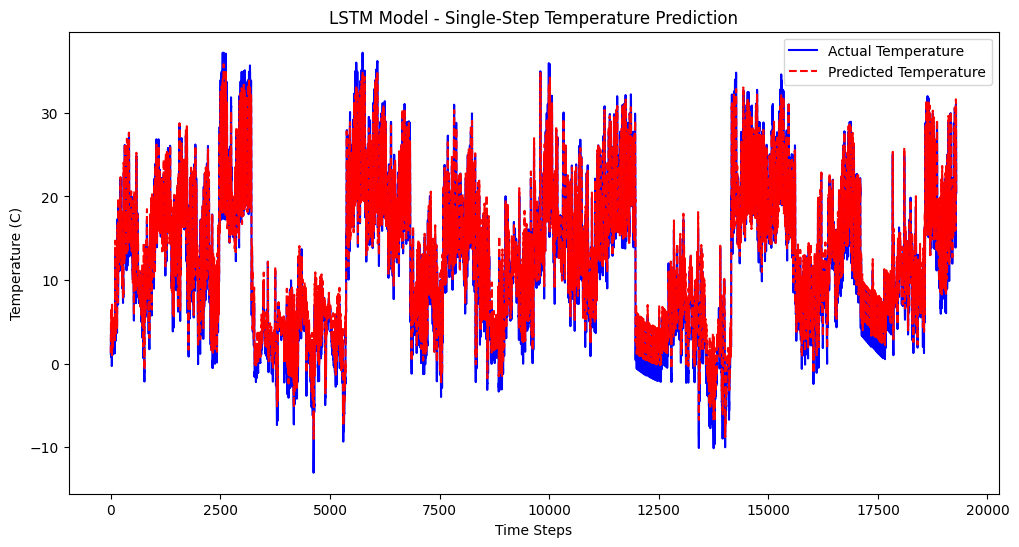

In [8]:
# Make predictions
y_pred_s = model_single.predict(X_test_s)

# Inverse transform predictions and actual values
y_pred_rescaled_s = scaler.inverse_transform(y_pred_s)
y_test_rescaled_s = scaler.inverse_transform(y_test_s)

# Plot actual vs predicted temperature
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled_s[:, 0], label="Actual Temperature", color='blue')
plt.plot(y_pred_rescaled_s[:, 0], label="Predicted Temperature", color='red', linestyle='dashed')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Temperature (C)")
plt.title("LSTM Model - Single-Step Temperature Prediction")
plt.show()


In [9]:
# Generate single-step predictions
y_pred_s = model_single.predict(X_test_s)

# Inverse transform predictions and actual values
y_pred_rescaled_s = scaler.inverse_transform(y_pred_s)
y_test_rescaled_s = scaler.inverse_transform(y_test_s)

# Generate timestamps for visualization
future_dates_s = [df.index[-1] + timedelta(hours=i+1) for i in range(len(y_pred_rescaled_s))]

# Create a DataFrame for single-step predictions
predictions_df_single = pd.DataFrame({
    'DateTime': future_dates_s,
    'Predicted Temperature (C)': y_pred_rescaled_s[:, 0],
    'Actual Temperature (C)': y_test_rescaled_s[:, 0]
})

# Display the predictions DataFrame in Google Colab
display(predictions_df_single)


603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


,DateTime,Predicted Temperature (C),Actual Temperature (C)
0,2016-09-09 22:00:00,1.275723,1.138889
1,2016-09-09 23:00:00,2.118132,2.222222
2,2016-09-10 00:00:00,2.710352,2.916667
3,2016-09-10 01:00:00,3.834466,2.894444
4,2016-09-10 02:00:00,4.502145,2.933333
...,...,...,...
19284,2018-11-22 10:00:00,28.639868,26.016667
19285,2018-11-22 11:00:00,23.972179,24.583333
19286,2018-11-22 12:00:00,22.926453,22.038889
19287,2018-11-22 13:00:00,20.328835,21.522222


In [10]:
# Function to create sequences for multi-step forecasting
def create_multi_step_sequences(data, input_length=10, output_length=5):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i+input_length])  # Input past `input_length` timesteps
        y.append(data[i+input_length:i+input_length+output_length])  # Predict next `output_length` timesteps
    return np.array(X), np.array(y)

# Define output length
output_length = 5

# Create sequences
X_multi, y_multi = create_multi_step_sequences(scaled_data, input_length, output_length)

# Split into training (80%) and testing (20%) sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.2, shuffle=False)

# Print dataset shape
print("X_train_m shape:", X_train_m.shape)
print("y_train_m shape:", y_train_m.shape)


X_train_m shape: (77151, 10, 5)
y_train_m shape: (77151, 5, 5)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 57s 42ms/step - loss: 0.0702 - mae: 0.1841 - val_loss: 0.0097 - val_mae: 0.0698
Epoch 2/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0162 - mae: 0.0917 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 3/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - loss: 0.0128 - mae: 0.0789 - val_loss: 0.0068 - val_mae: 0.0530
Epoch 4/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - loss: 0.0111 - mae: 0.0705 - val_loss: 0.0062 - val_mae: 0.0468
Epoch 5/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0103 - mae: 0.0651 - val_loss: 0.0057 - val_mae: 0.0441
Epoch 6/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - loss: 0.0096 - mae: 0.0615 - val_loss: 0.0059 - val_mae: 0.0476
Epoch 7/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 0.0094 - mae: 0.0595 - val_loss: 0.0056 - val_mae: 0.0448
Epoch 8/20
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - loss: 0.0091 - mae: 0.0582 - val_loss: 0.0054 - val_mae: 0.0434
Epoch 9/20
1206/1206 ━━━━━━━━━━━━━━

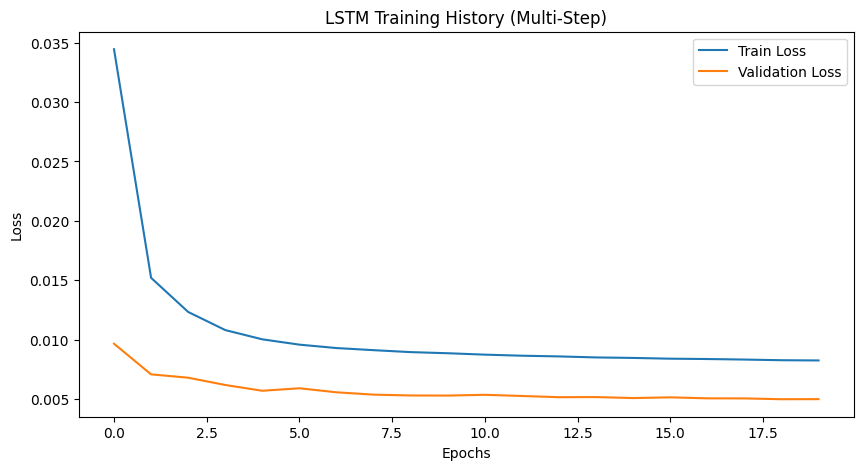

In [11]:
# Define LSTM model for multi-step forecasting
model_multi = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(input_length, X_train_m.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(output_length * X_train_m.shape[2])  # Predict multiple future time steps
])

# Compile the model
model_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history_multi = model_multi.fit(
    X_train_m, y_train_m.reshape(y_train_m.shape[0], -1),
    epochs=20, batch_size=64,
    validation_data=(X_test_m, y_test_m.reshape(y_test_m.shape[0], -1))
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history_multi.history['loss'], label='Train Loss')
plt.plot(history_multi.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training History (Multi-Step)')
plt.show()


603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


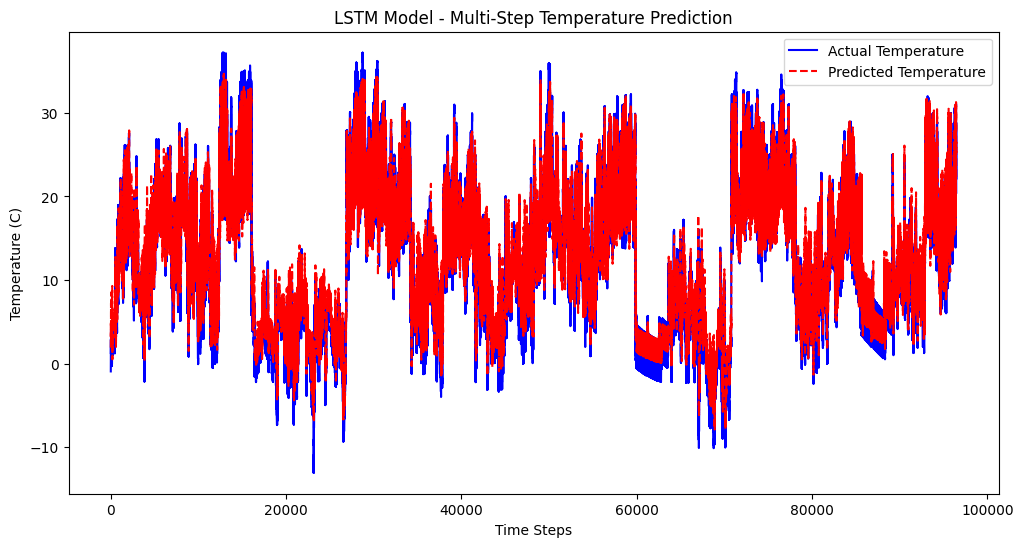

In [12]:
# Make predictions
y_pred_m = model_multi.predict(X_test_m)

# Reshape predictions to match original format
y_pred_m = y_pred_m.reshape(-1, output_length, X_test_m.shape[2])
y_test_m = y_test_m.reshape(-1, output_length, X_test_m.shape[2])

# Inverse transform predictions
y_pred_rescaled_m = scaler.inverse_transform(y_pred_m.reshape(-1, X_test_m.shape[2]))[:, 0]
y_test_rescaled_m = scaler.inverse_transform(y_test_m.reshape(-1, X_test_m.shape[2]))[:, 0]

# Plot actual vs predicted temperature
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled_m, label="Actual Temperature", color='blue')
plt.plot(y_pred_rescaled_m, label="Predicted Temperature", color='red', linestyle='dashed')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Temperature (C)")
plt.title("LSTM Model - Multi-Step Temperature Prediction")
plt.show()


In [14]:
# Generate multi-step predictions
y_pred_m = model_multi.predict(X_test_m)

# Reshape predictions to match the original format
num_features = X_test_m.shape[2]
y_pred_m = y_pred_m.reshape(-1, output_length, num_features)
y_test_m = y_test_m.reshape(-1, output_length, num_features)

# Inverse transform predictions and actual values
y_pred_rescaled_m = scaler.inverse_transform(y_pred_m.reshape(-1, num_features))[:, 0]
y_test_rescaled_m = scaler.inverse_transform(y_test_m.reshape(-1, num_features))[:, 0]

# Generate timestamps for visualization
future_dates_m = [df.index[-1] + timedelta(hours=i+1) for i in range(len(y_pred_rescaled_m))]

# Create a DataFrame for multi-step predictions
predictions_df_multi = pd.DataFrame({
    'DateTime': future_dates_m,
    'Predicted Temperature (C)': y_pred_rescaled_m,
    'Actual Temperature (C)': y_test_rescaled_m
})

# Display the predictions DataFrame in Google Colab
from IPython.display import display
display(predictions_df_multi)


603/603 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step


,DateTime,Predicted Temperature (C),Actual Temperature (C)
0,2016-09-09 22:00:00,1.901109,-0.944444
1,2016-09-09 23:00:00,2.015347,0.072222
2,2016-09-10 00:00:00,2.014272,0.355556
3,2016-09-10 01:00:00,2.177022,1.138889
4,2016-09-10 02:00:00,2.454216,2.222222
...,...,...,...
96435,2027-09-11 01:00:00,27.693600,26.016667
96436,2027-09-11 02:00:00,26.515713,24.583333
96437,2027-09-11 03:00:00,25.209766,22.038889
96438,2027-09-11 04:00:00,23.675669,21.522222
